<a href="https://colab.research.google.com/github/Dmitriy6655/Sem_06-Rabota-s-dannimi/blob/main/Sem_06_Rabota_s_dannimi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Работа с данными. Домашнее задание 6

**Задача**

Имеется набор данных покупателей супермаркета. Проведите анализ и очистку этих данных.
Описание данных

Дан файл Mall_Customers.csv, содержащий следующие данные по покупателям сети супермаркетов:

    CustomerID — идентификатор покупателя.
    Genre – пол покупателя.
    Age – возраст покупателя.
    Annual Income (k$) – годовой доход покупателя, тысяч $.
    Spending Score (1–100) – рейтинг покупателя, целевая переменная.

Задание 1

Загрузите данные из файла Mall_Customers.csv в ноутбук и выведите первые пять строк на экран.

In [24]:
import pandas as pd

df = pd.read_csv('Mall_Customers.csv').drop('CustomerID', axis=1)
df.head()

,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,Male,19.0,15.0,39
1,Male,NaN,NaN,81
2,Female,NaN,16.0,6
3,Female,23.0,16.0,77
4,Female,31.0,17.0,40



Задание 2

Проведите разведочный анализ загруженных данных. Обязательные атрибуты для анализа:

    количество пропусков в каждом признаке;
    распределения признаков;
    возможные выбросы или аномалии.

Анализ дополнительных атрибутов и свойств данных приветствуется. Используйте средства визуализации там, где это необходимо.

По результатам анализа сделайте выводы о свойствах отдельных признаков и качестве данных в целом.


In [25]:
df.shape

(200, 4)

In [26]:
# Проверим наличие пропусков
df.isna().sum()

,0
Genre,19
Age,20
Annual Income (k$),20
Spending Score (1-100),0


In [27]:
# % пропущенных значений
df.isna().sum() / df.shape[0] * 100

,0
Genre,9.5
Age,10.0
Annual Income (k$),10.0
Spending Score (1-100),0.0


In [28]:
# Проверим строки где 2 и более пропусков
df_miss_row = df[df.isna().sum(axis=1) >= 2]
df_miss_row.head(df_miss_row.shape[0])

,Genre,Age,Annual Income (k$),Spending Score (1-100)
1,Male,NaN,NaN,81
46,Female,NaN,NaN,55
54,NaN,50.0,NaN,45
106,NaN,NaN,63.0,50
123,NaN,39.0,NaN,91


In [29]:
# описание признаков
df.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
Age,180.0,39.89,16.84,18.0,29.00,36.0,49.0,135.0
Annual Income (k$),180.0,5615.43,74531.12,15.0,42.00,61.0,78.0,1000000.0
Spending Score (1-100),200.0,50.20,25.82,1.0,34.75,50.0,73.0,99.0


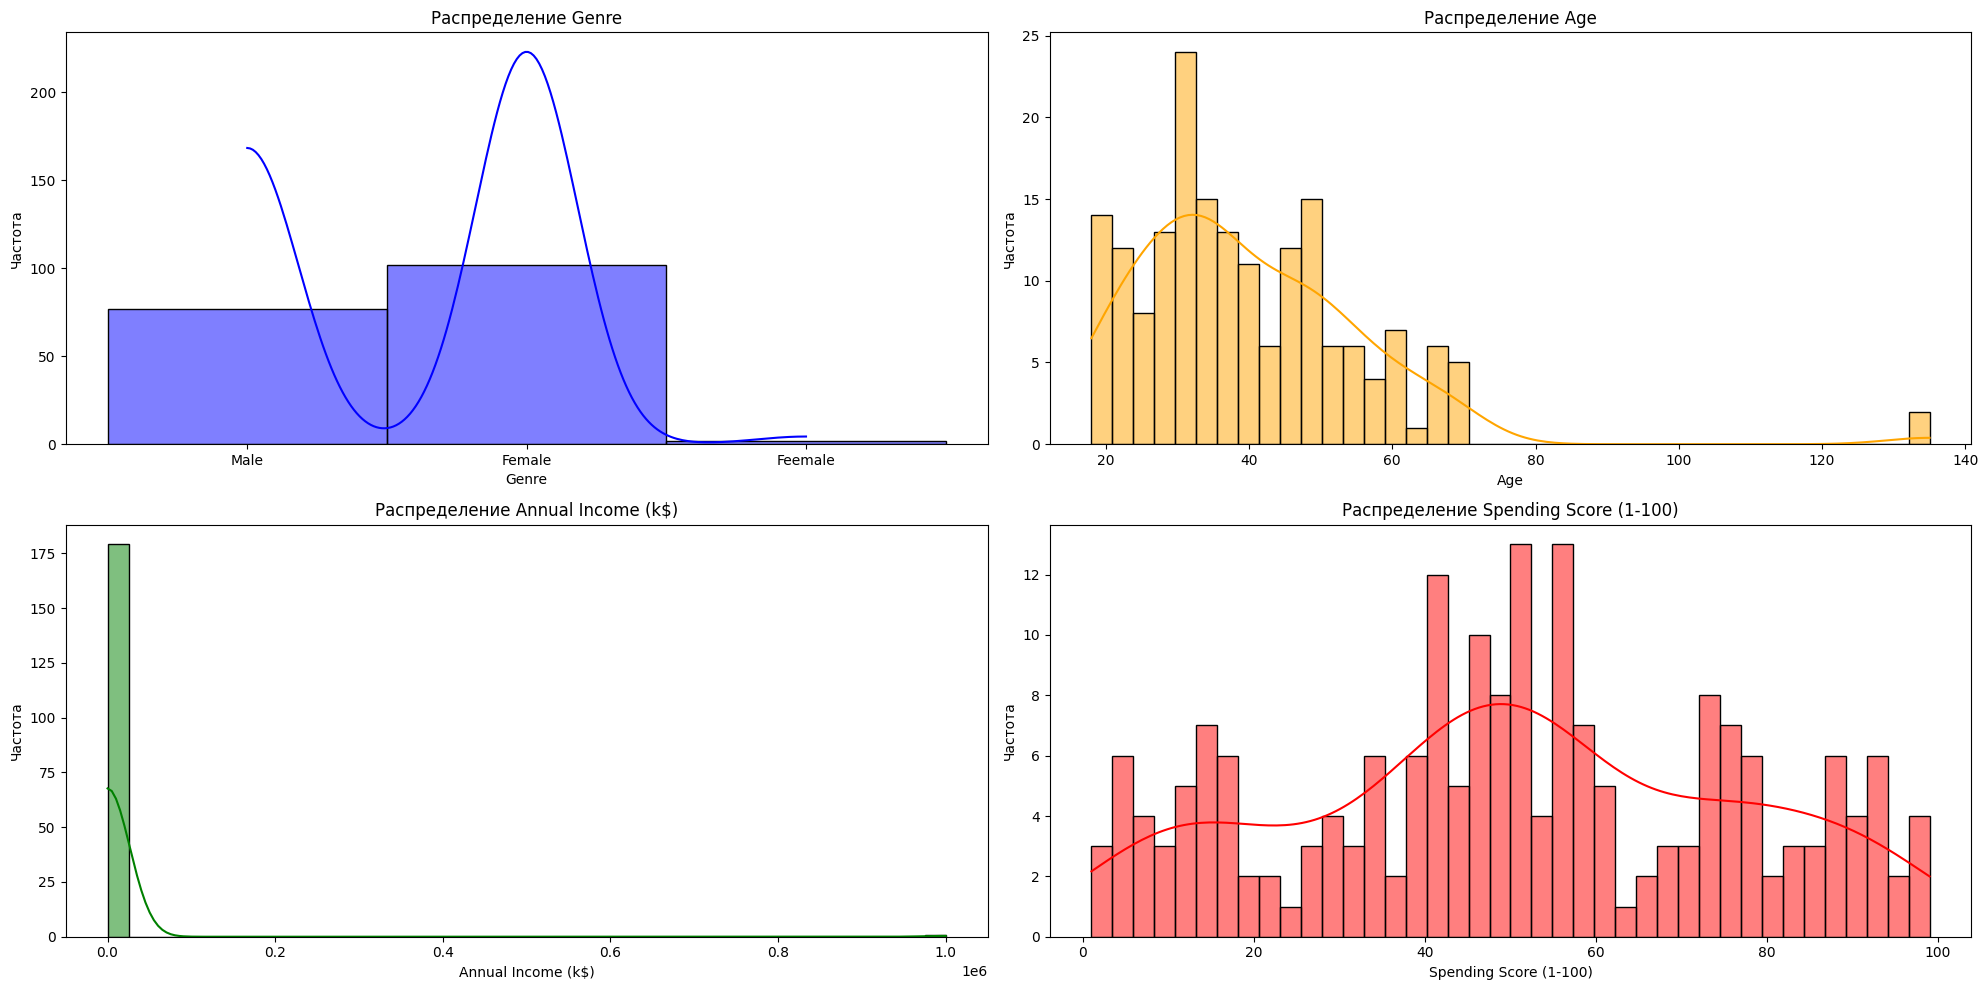

In [30]:
# визуализируем данные
import matplotlib.pyplot as plt
import seaborn as sns

# функция для гистограммы
def plot_hist(data):
    color_list = ['blue', 'orange', 'green', 'red']
    i = 0
    fig, axs = plt.subplots(2, 2, figsize=(20, 10))
    for ax in axs.flat:
        if i < len(data.columns):
            sns.histplot(data[data.columns[i]], bins=40, kde=True, color=color_list[i], ax=ax)
            ax.set_title(f'Распределение {data.columns[i]}')
            ax.set_xlabel(data.columns[i])
            ax.set_ylabel('Частота')
            i+=1
    plt.tight_layout()
    plt.show()

plot_hist(df)



Выводы:

Есть выбросы в признаках Age и Annual Income (k$). Есть ошибка в признаке Genre. В данных есть пропуски но ни один из признаков мы не можем удалить, так как количество пропусков не превышает 10%.



**Задание 3**

Разделите данные на обучающую и тестовую выборки в пропорции 80:20. Здесь и далее используйте random_state = 1.


In [31]:
# разбиваем данные на обучающую и тестовую
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(df, test_size=0.2, random_state=1)


**Задание 4**

Заполните пропуски в признаках в обучающей выборке с использованием инструментов sklearn. Для каждого признака выберите и аргументируйте стратегию заполнения пропусков.


In [32]:
#  Заполняем пропуски
from sklearn.impute import SimpleImputer

# Так как Age и Annual Income (k$) имеет несколько выбросов, медиана лучше справиться с задачей
num_imputer = SimpleImputer(strategy='median')

# Для Genre заполнения наиболее часто встречающимся значением минимизирует вероятность искажения данных, сохраняя структуру и баланс категорий.
cat_imputer = SimpleImputer(strategy='most_frequent')

train_data['Age'] = num_imputer.fit_transform(train_data[['Age']])
train_data['Annual Income (k$)'] = num_imputer.fit_transform(train_data[['Annual Income (k$)']])
train_data['Genre'] = cat_imputer.fit_transform(train_data[['Genre']]).ravel()


In [33]:
# Проверим наличие пропусков
train_data.isna().sum()

,0
Genre,0
Age,0
Annual Income (k$),0
Spending Score (1-100),0



**Задание 5**

Найдите выбросы в признаках обучающей выборки. Замените выбросы, если таковые имеются, и аргументируйте выбор метода поиска выбросов.


In [34]:
# Функция для поиска и замены выбросов медианными значениями
def replace_outliers_with_median(data, column):
    # Рассчитываем квартильные значения и IQR
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1

    # Определяем нижнюю и верхнюю границы для выбросов
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Вычисляем медианное значение для замены выбросов
    median_value = data[column].median()

    # Заменяем значения, которые являются выбросами, на медиану
    data[column] = data[column].apply(
        lambda x: median_value if x < lower_bound or x > upper_bound else x)

# Применение функции для замены выбросов'
replace_outliers_with_median(train_data, 'Age')
replace_outliers_with_median(train_data, 'Annual Income (k$)')

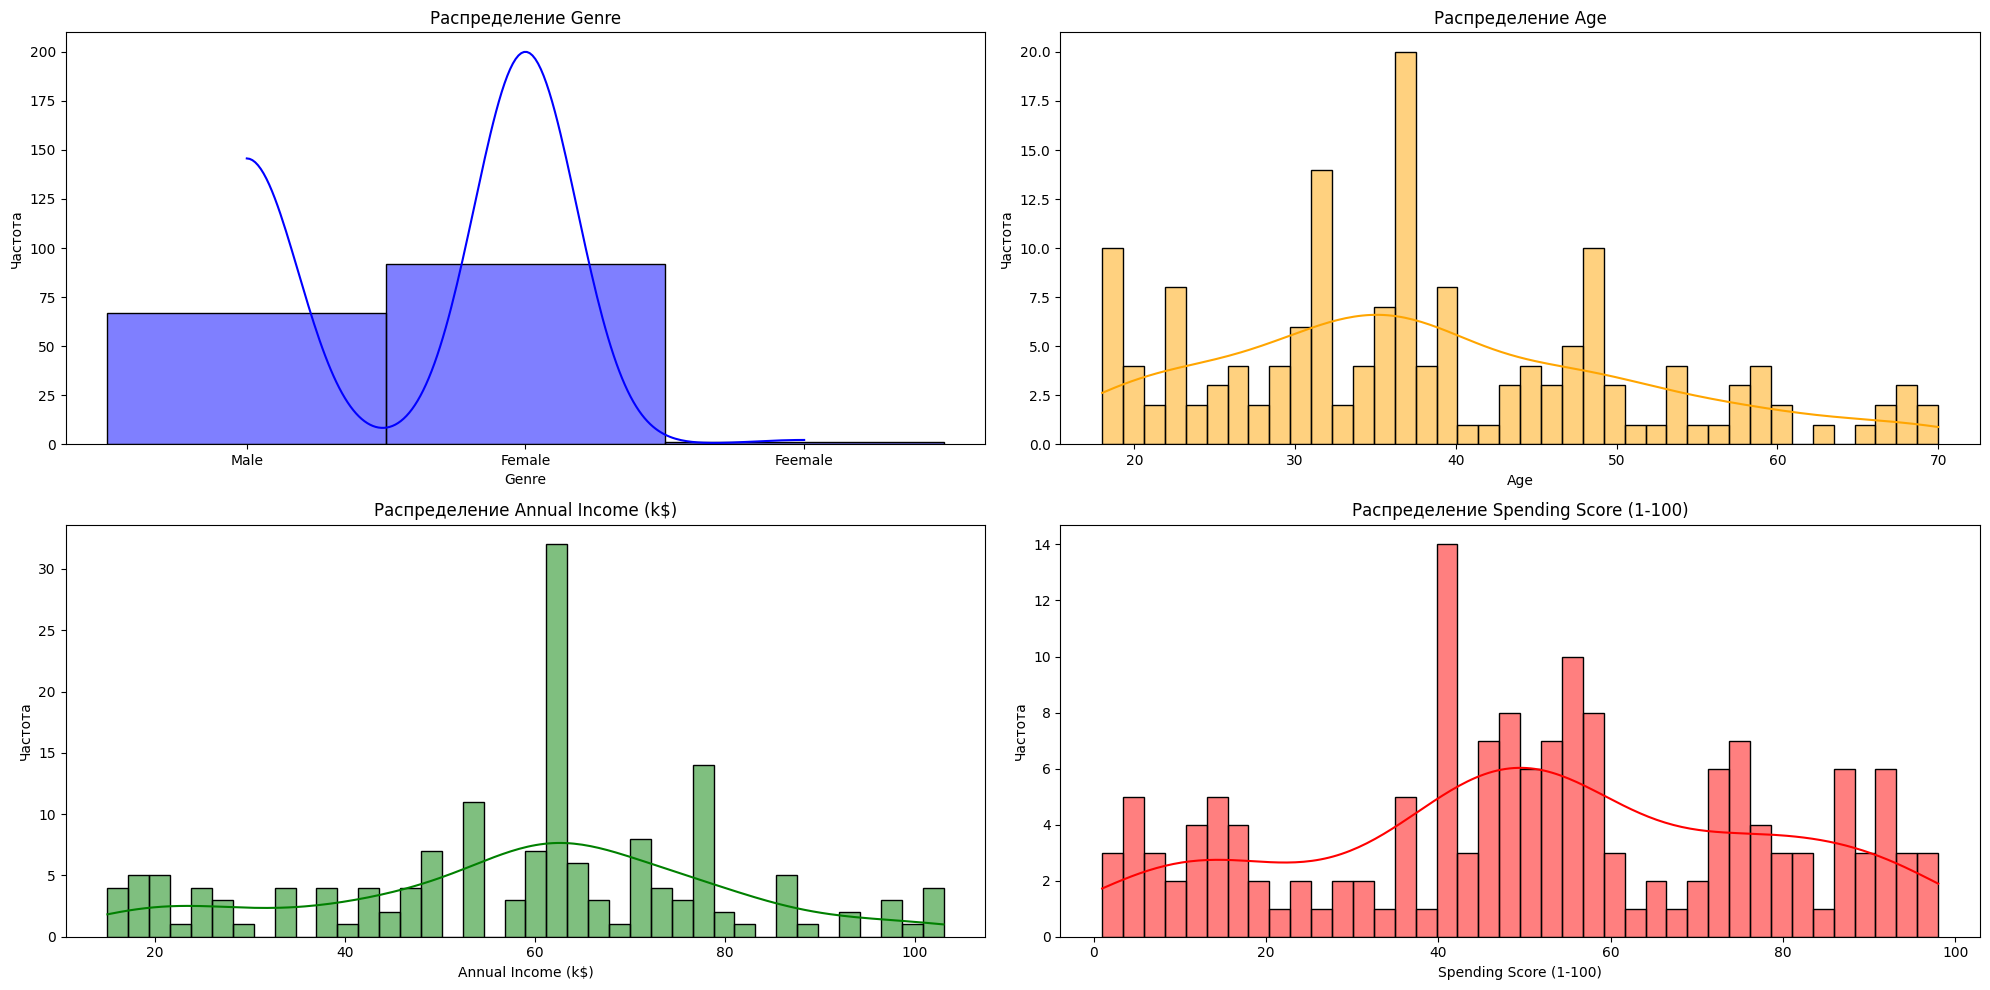

In [35]:
# визуализируем обновлённые данные
plot_hist(train_data)

In [36]:
# Заменяем неправильные значения 'Fеemale' на 'Female'
train_data['Genre'] = train_data['Genre'].replace('Feemale', 'Female')

# Проверим уникальные значения
train_data['Genre'].value_counts()

,count
Genre,
Female,93
Male,67



**Задание 6**

Нормализуйте численные признаки. Аргументируйте выбор стратегии нормализации для каждого признака.



In [37]:
# нормализуем данные
from sklearn.preprocessing import StandardScaler
# так как данные имеют распределение, близкое к нормальному, то нормализуем их с помощью функции StandardScaler
scaler = StandardScaler()
train_data[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']] = scaler.fit_transform(train_data[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']])
train_data.head()

,Genre,Age,Annual Income (k$),Spending Score (1-100)
108,Male,2.295277,0.212261,-0.321304
107,Male,1.211960,0.212261,-0.205952
189,Female,-0.180875,2.109563,1.293627
14,Male,-0.103495,-1.827340,-1.474827
56,Female,0.979821,-0.688958,-0.052149



**Задание 7**

Закодируйте категориальные признаки в обучающей выборке. Аргументируйте выбор способа кодирования.


In [38]:
# Закодируем признак Genre
from sklearn.preprocessing import LabelEncoder

# Используем LabelEncoder так как он оптимально решает задачу для случая с двумя категориями, как в данном примере с полом.
encoder = LabelEncoder()
train_data['Genre'] = encoder.fit_transform(train_data['Genre'])
train_data.head()


,Genre,Age,Annual Income (k$),Spending Score (1-100)
108,1,2.295277,0.212261,-0.321304
107,1,1.211960,0.212261,-0.205952
189,0,-0.180875,2.109563,1.293627
14,1,-0.103495,-1.827340,-1.474827
56,0,0.979821,-0.688958,-0.052149



**Задание 8**

Проведите очистку и подготовку тестовых данных. Используйте препроцессоры и другие инструменты, которые вы уже использовали при подготовке обучающей выборки, без их дополнительной настройки.


In [39]:
# посмотрим на ошибки в Genre
test_data['Genre'].value_counts()

,count
Genre,
Female,25
Male,10
Feemale,1


In [40]:
# Заполнение пропусков в тестовых данных
test_data['Age'] = num_imputer.fit_transform(test_data[['Age']])
test_data['Annual Income (k$)'] = num_imputer.fit_transform(test_data[['Annual Income (k$)']])
test_data['Genre'] = cat_imputer.fit_transform(test_data[['Genre']]).ravel()

# Нормализация тестовых данных
test_data[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']] = scaler.fit_transform(test_data[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']])

# устраняем выбросы
replace_outliers_with_median(test_data, 'Age')
replace_outliers_with_median(test_data, 'Annual Income (k$)')
test_data['Genre'] = test_data['Genre'].replace('Feemale', 'Female')

# Кодирование тестовых данных
test_data['Genre'] = encoder.fit_transform(test_data['Genre'])


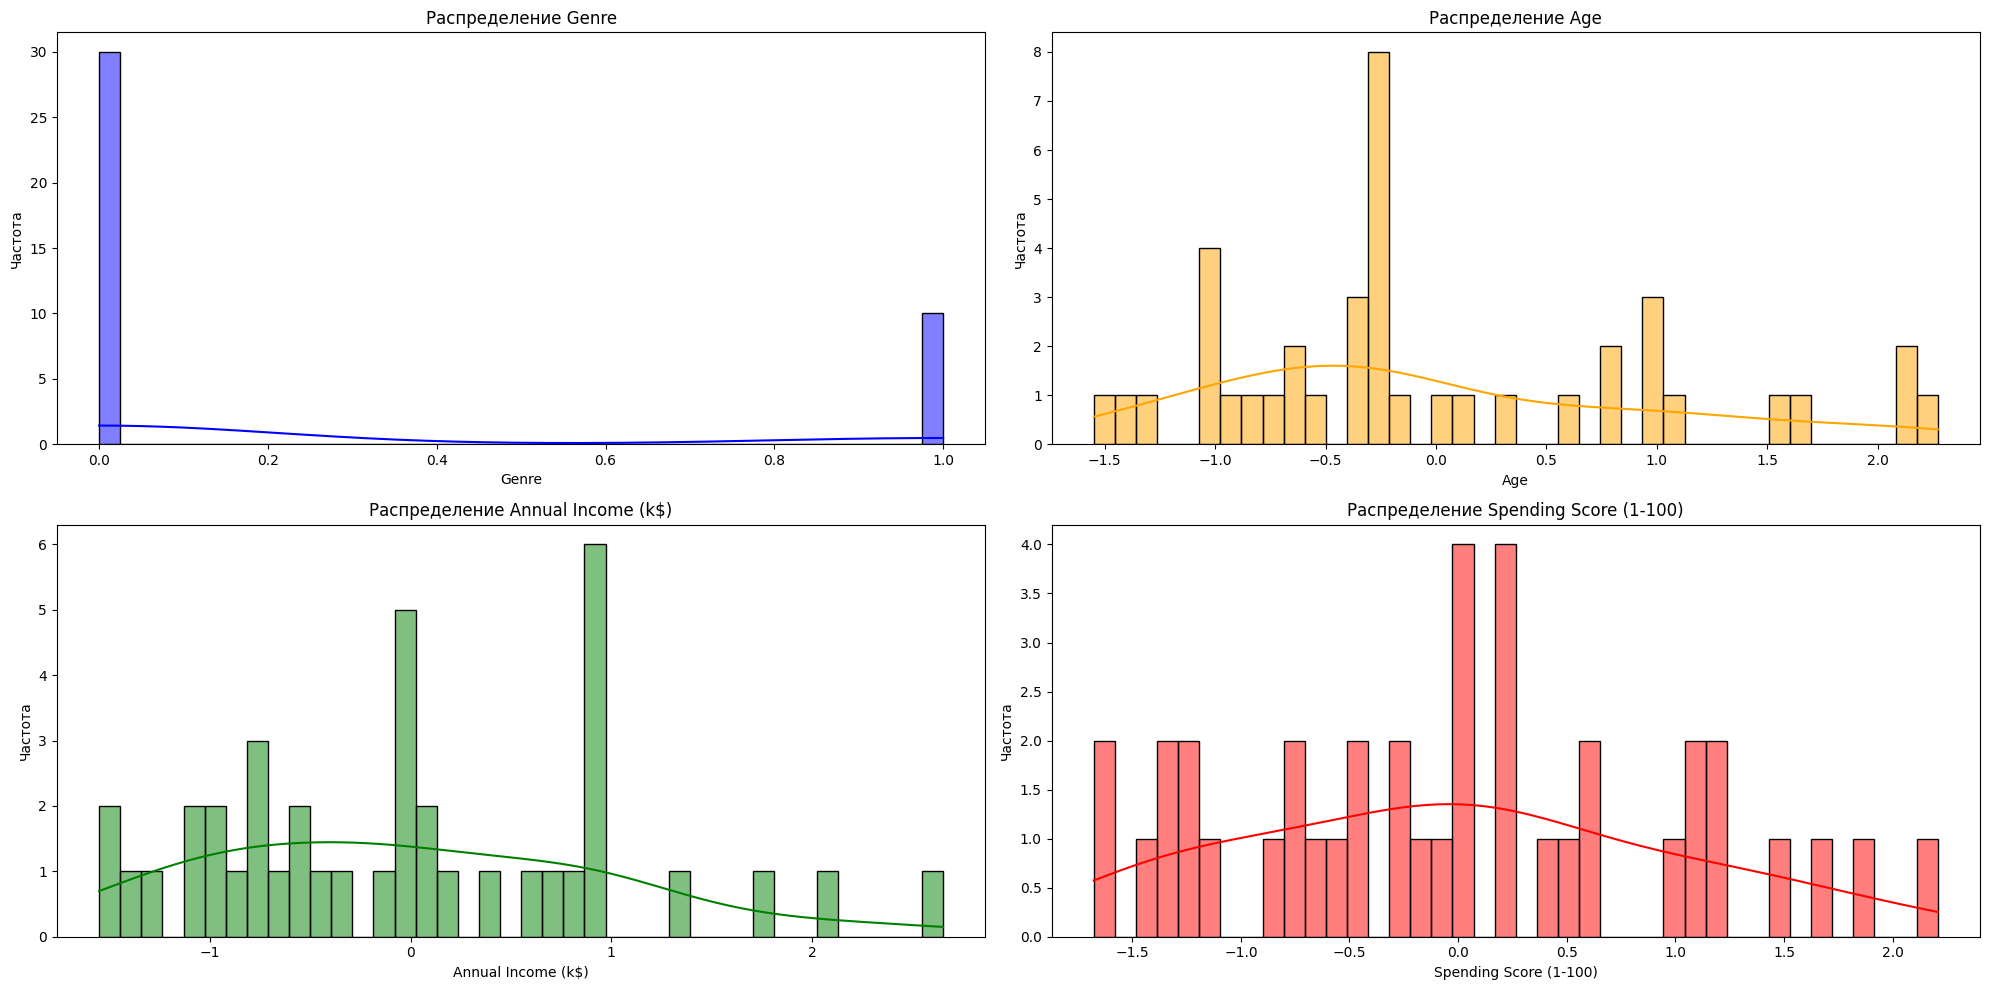

In [41]:
# визуализируем обновлённые данные
plot_hist(test_data)